In [ ]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt -O imagenet_classes.txt


--2025-03-06 04:17:13--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2025-03-06 04:17:13 (54.2 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



Saving Dog_Breeds.jpg to Dog_Breeds (2).jpg
✅ Uploaded image: Dog_Breeds (2).jpg
✅ Original Prediction: golden retriever
Step 0, Loss: -12.306772232055664
Step 100, Loss: -98.77436065673828
Step 200, Loss: -110.1825180053711
Step 300, Loss: -116.28988647460938
Step 400, Loss: -120.62725067138672
Step 500, Loss: -124.09882354736328
Step 600, Loss: -127.120361328125
Step 700, Loss: -129.05503845214844
Step 800, Loss: -130.5465850830078
Step 900, Loss: -131.5786895751953


🚀 Adversarial Prediction: paper towel


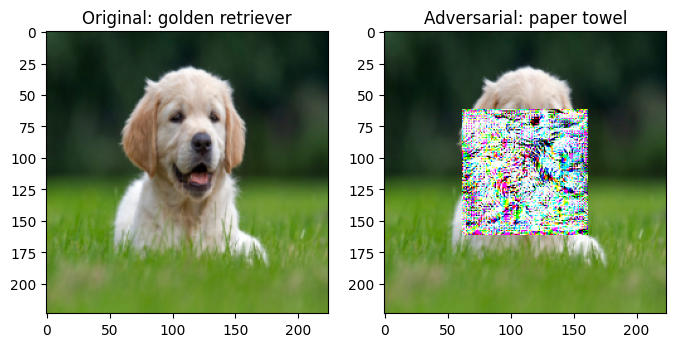

✅ Patch saved as adversarial_patch.png


In [6]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

from google.colab import files
uploaded = files.upload()

image_path = list(uploaded.keys())[0]
print(f"✅ Uploaded image: {image_path}")

image = Image.open(image_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

input_tensor = transform(image).unsqueeze(0)

model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
model.eval()

imagenet_classes = models.ResNet34_Weights.IMAGENET1K_V1.meta["categories"]

output = model(input_tensor)
pred_label = imagenet_classes[output.argmax().item()]
print(f"✅ Original Prediction: {pred_label}")

patch_size = (100, 100)

patch = torch.ones(3, *patch_size, requires_grad=True)
x_offset, y_offset = 62, 62

def apply_patch(image_tensor, patch, x_offset, y_offset):
    patched_image = image_tensor.clone()
    patch = patch.unsqueeze(0)
    patched_image[:, :, y_offset:y_offset+patch_size[1], x_offset:x_offset+patch_size[0]] = patch
    return patched_image

optimizer = torch.optim.Adam([patch], lr=0.05)

target_class = 609

for i in range(1000):
    patched_image = apply_patch(input_tensor, patch, x_offset, y_offset)
    output = model(patched_image)

    loss = -F.cross_entropy(output, torch.tensor([target_class], dtype=torch.long))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print(f"Step {i}, Loss: {loss.item()}")

patched_output = model(apply_patch(input_tensor, patch, x_offset, y_offset))
patched_pred_label = imagenet_classes[patched_output.argmax().item()]
print(f"🚀 Adversarial Prediction: {patched_pred_label}")

plt.figure(figsize=(8,4))

# Original image
plt.subplot(1,2,1)
plt.imshow(input_tensor.squeeze().permute(1,2,0).detach().cpu().numpy())
plt.title(f"Original: {pred_label}")

# Patched image
plt.subplot(1,2,2)
plt.imshow(apply_patch(input_tensor, patch, x_offset, y_offset).squeeze().permute(1,2,0).detach().cpu().numpy())
plt.title(f"Adversarial: {patched_pred_label}")

plt.show()


patch_image = patch.detach().squeeze().permute(1,2,0).cpu().numpy()

patch_image = np.clip(patch_image, 0, 1)

# Save the patch as an image
plt.imsave("adversarial_patch.png", patch_image)
print("✅ Patch saved as adversarial_patch.png")


Saving download.jpeg to download.jpeg
✅ Uploaded new image: download.jpeg
✅ New Image Original Prediction: tabby
🚀 New Image Adversarial Prediction: paper towel


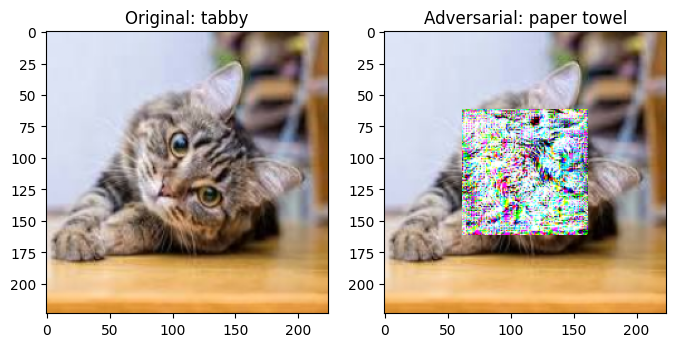

In [7]:
# Install necessary packages if not already installed
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

from google.colab import files
uploaded = files.upload()

new_image_path = list(uploaded.keys())[0]
print(f"✅ Uploaded new image: {new_image_path}")


new_image = Image.open(new_image_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

new_input_tensor = transform(new_image).unsqueeze(0)  # Add batch dimension

model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
model.eval()

imagenet_classes = models.ResNet34_Weights.IMAGENET1K_V1.meta["categories"]

new_output = model(new_input_tensor)
new_pred_label = imagenet_classes[new_output.argmax().item()]
print(f"✅ New Image Original Prediction: {new_pred_label}")

patch = Image.open("adversarial_patch.png").convert("RGB")  # Load saved patch
patch = transform(patch)  # Convert to tensor

patch_size = (100, 100)
patch = torch.nn.functional.interpolate(patch.unsqueeze(0), size=patch_size, mode='bilinear', align_corners=False).squeeze(0)

x_offset, y_offset = 62, 62

def apply_saved_patch(image_tensor, patch, x_offset, y_offset):
    patched_image = image_tensor.clone()
    patched_image[:, :, y_offset:y_offset+patch_size[1], x_offset:x_offset+patch_size[0]] = patch
    return patched_image

patched_new_image = apply_saved_patch(new_input_tensor, patch, x_offset, y_offset)

patched_output = model(patched_new_image)
patched_pred_label = imagenet_classes[patched_output.argmax().item()]
print(f"🚀 New Image Adversarial Prediction: {patched_pred_label}")

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(new_input_tensor.squeeze().permute(1,2,0).detach().cpu().numpy())
plt.title(f"Original: {new_pred_label}")

plt.subplot(1,2,2)
plt.imshow(patched_new_image.squeeze().permute(1,2,0).detach().cpu().numpy())
plt.title(f"Adversarial: {patched_pred_label}")

plt.show()


Saving download.jpeg to download (4).jpeg
✅ Uploaded new image: download (4).jpeg
✅ New Image Original Prediction: tabby
🚀 New Image Adversarial Prediction: paper towel


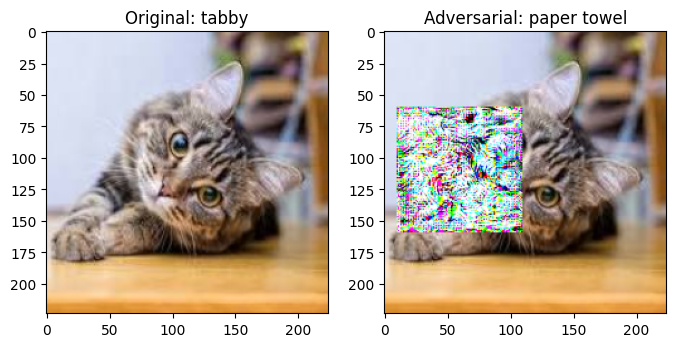

In [11]:
# Install necessary packages if not already installed
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

from google.colab import files
uploaded = files.upload()

new_image_path = list(uploaded.keys())[0]
print(f"✅ Uploaded new image: {new_image_path}")


new_image = Image.open(new_image_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

new_input_tensor = transform(new_image).unsqueeze(0)  # Add batch dimension

model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
model.eval()

imagenet_classes = models.ResNet34_Weights.IMAGENET1K_V1.meta["categories"]

new_output = model(new_input_tensor)
new_pred_label = imagenet_classes[new_output.argmax().item()]
print(f"✅ New Image Original Prediction: {new_pred_label}")

patch = Image.open("adversarial_patch.png").convert("RGB")  # Load saved patch
patch = transform(patch)  # Convert to tensor

patch_size = (100, 100)
patch = torch.nn.functional.interpolate(patch.unsqueeze(0), size=patch_size, mode='bilinear', align_corners=False).squeeze(0)

x_offset, y_offset = 10, 60

def apply_saved_patch(image_tensor, patch, x_offset, y_offset):
    patched_image = image_tensor.clone()
    patched_image[:, :, y_offset:y_offset+patch_size[1], x_offset:x_offset+patch_size[0]] = patch
    return patched_image

patched_new_image = apply_saved_patch(new_input_tensor, patch, x_offset, y_offset)

patched_output = model(patched_new_image)
patched_pred_label = imagenet_classes[patched_output.argmax().item()]
print(f"🚀 New Image Adversarial Prediction: {patched_pred_label}")

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(new_input_tensor.squeeze().permute(1,2,0).detach().cpu().numpy())
plt.title(f"Original: {new_pred_label}")

plt.subplot(1,2,2)
plt.imshow(patched_new_image.squeeze().permute(1,2,0).detach().cpu().numpy())
plt.title(f"Adversarial: {patched_pred_label}")

plt.show()
